# Exploratory Spatial Data Analysis (ESDA)

> [`IPYNB`](../content/part1/04_esda.ipynb)


In [1]:
%matplotlib inline
import pysal as ps
import pandas as pd
import numpy as np
from pysal.contrib.viz import mapping as maps

A well-used functionality in PySAL is the use of PySAL to conduct exploratory spatial data analysis. This notebook will provide an overview of ways to conduct exploratory spatial analysis in Python. 

First, let's read in some data:

In [2]:
data = ps.pdio.read_files("../data/texas.shp")

In [3]:
data.head()

,NAME,STATE_NAME,STATE_FIPS,CNTY_FIPS,FIPS,STFIPS,COFIPS,FIPSNO,SOUTH,HR60,...,BLK90,GI59,GI69,GI79,GI89,FH60,FH70,FH80,FH90,geometry
0,Lipscomb,Texas,48,295,48295,48,295,48295,1,0.0,...,0.031817,0.286929,0.378219,0.407005,0.373005,6.724512,4.5,3.835360,6.093580,<pysal.cg.shapes.Polygon object at 0x7fd6da8ad...
1,Sherman,Texas,48,421,48421,48,421,48421,1,0.0,...,0.139958,0.288976,0.359377,0.415453,0.378041,5.665722,1.7,3.253796,3.869407,<pysal.cg.shapes.Polygon object at 0x7fd6da8ad...
2,Dallam,Texas,48,111,48111,48,111,48111,1,0.0,...,2.050906,0.331667,0.385996,0.370037,0.376015,7.546049,7.2,9.471366,14.231738,<pysal.cg.shapes.Polygon object at 0x7fd6da8ad...
3,Hansford,Texas,48,195,48195,48,195,48195,1,0.0,...,0.000000,0.253527,0.357813,0.393938,0.383924,7.591786,4.7,5.542986,7.125457,<pysal.cg.shapes.Polygon object at 0x7fd6da8ad...
4,Ochiltree,Texas,48,357,48357,48,357,48357,1,0.0,...,0.021911,0.236998,0.352940,0.343949,0.374461,5.172414,4.0,4.758392,9.159159,<pysal.cg.shapes.Polygon object at 0x7fd6da8ad...


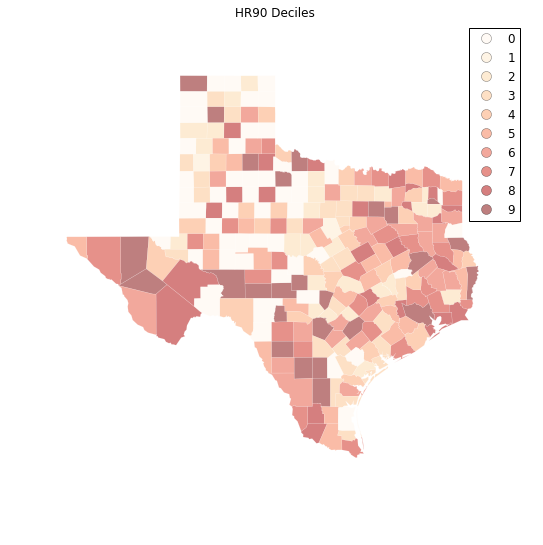

In [4]:
import matplotlib.pyplot as plt

import geopandas as gpd
shp_link = "../data/texas.shp"
tx = gpd.read_file(shp_link)
hr10 = ps.Quantiles(data.HR90, k=10)
f, ax = plt.subplots(1, figsize=(9, 9))
tx.assign(cl=hr10.yb).plot(column='cl', categorical=True, \
        k=10, cmap='OrRd', linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("HR90 Deciles")
plt.show()

## Spatial Autocorrelation

Visual inspection of the map pattern for HR90 deciles allows us to search for spatial structure. If the spatial distribution of the rates was random, then we should not see any clustering of similar values on the map. However, our visual system is drawn to the darker clusters in the south west as well as the east, and a concentration of the lighter hues (lower homicide rates) moving north to the pan handle.

Our brains are very powerful pattern recognition machines. However, sometimes they can be too powerful and lead us to detect false positives, or patterns where there are no statistical patterns. This is a particular concern when dealing with visualization of irregular polygons of differning sizes and shapes.

The concept of *spatial autocorrelation* relates to the combination of two types of similarity: spatial similarity and attribute similarity. Although there are many different measures of spatial autocorrelation, they all combine these two types of simmilarity into a summary measure.

Let's use PySAL to generate these two types of similarity measures.

### Spatial Similarity

We have already encountered spatial weights in a previous notebook. In spatial autocorrelation analysis, the spatial weights are used to formalize the notion of spatial similarity. As we have seen there are many ways to define spatial weights, here we will use queen contiguity:

In [5]:

data = ps.pdio.read_files("../data/texas.shp")
W = ps.queen_from_shapefile("../data/texas.shp")
W.transform = 'r'

### Attribute Similarity

So the spatial weight between counties $i$ and $j$ indicates if the two counties are neighbors (i.e., geographically similar). What we also need is a measure of attribute similarity to pair up with this concept of spatial similarity.
The **spatial lag** is a derived variable that accomplishes this for us. For county $i$ the spatial lag is defined as:
$$HR90Lag_i = \sum_j w_{i,j} HR90_j$$



In [6]:
HR90Lag = ps.lag_spatial(W, data.HR90)

In [7]:
HR90LagQ10 = ps.Quantiles(HR90Lag, k=10)

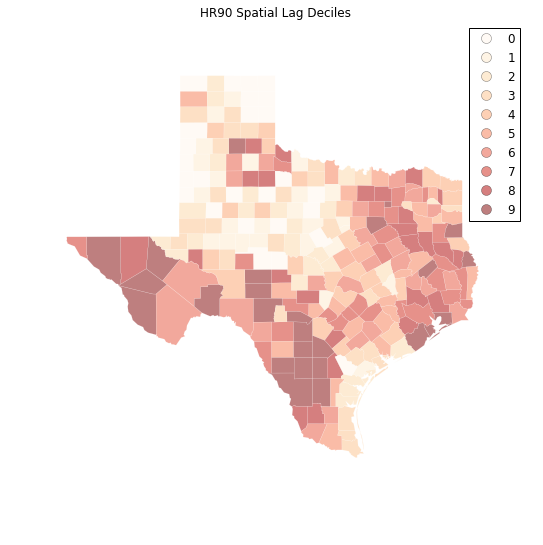

In [8]:
f, ax = plt.subplots(1, figsize=(9, 9))
tx.assign(cl=HR90LagQ10.yb).plot(column='cl', categorical=True, \
        k=10, cmap='OrRd', linewidth=0.1, ax=ax, \
        edgecolor='white', legend=True)
ax.set_axis_off()
plt.title("HR90 Spatial Lag Deciles")

plt.show()

The decile map for the spatial lag tends to enhance the impression of value similarity in space. However, we still have the challenge of visually associating the value of the homicide rate in a county with the value of the spatial lag of rates for the county. The latter is a weighted average of homicide rates in the focal county's neighborhood.

To complement the geovisualization of these associations we can turn to formal statistical measures of spatial autocorrelation.

In [9]:
HR90 = data.HR90
b,a = np.polyfit(HR90, HR90Lag, 1)

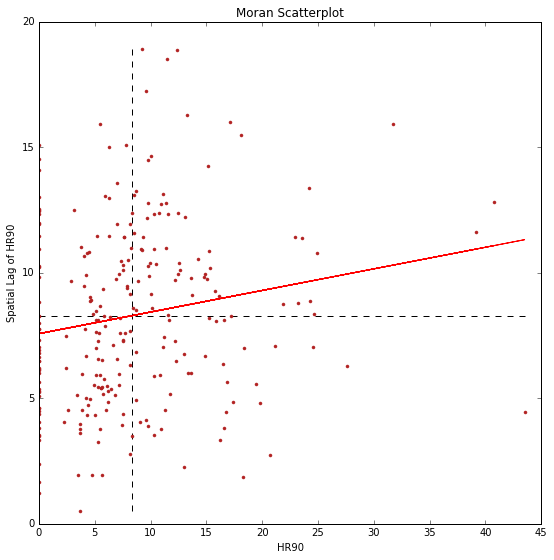

In [10]:
f, ax = plt.subplots(1, figsize=(9, 9))

plt.plot(HR90, HR90Lag, '.', color='firebrick')

 # dashed vert at mean of the last year's PCI
plt.vlines(HR90.mean(), HR90Lag.min(), HR90Lag.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(HR90Lag.mean(), HR90.min(), HR90.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(HR90, a + b*HR90, 'r')
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of HR90')
plt.xlabel('HR90')
plt.show()

## Global Spatial Autocorrelation

In PySAL, commonly-used analysis methods are very easy to access. For example, if we were interested in examining the spatial dependence in `HR90` we could quickly compute a Moran's $I$ statistic:

In [11]:
I_HR90 = ps.Moran(data.HR90.values, W)

In [12]:
I_HR90.I, I_HR90.p_sim

(0.085976640313889768, 0.012999999999999999)

Thus, the $I$ statistic is $0.859$ for this data, and has a very small $p$ value. 

In [13]:
b # note I is same as the slope of the line in the scatterplot

0.085976640313889505

We can visualize the distribution of simulated $I$ statistics using the stored collection of simulated statistics:

In [14]:
I_HR90.sim[0:5]

array([-0.05640543, -0.03158917,  0.0277026 ,  0.03998822, -0.01140814])

A simple way to visualize this distribution is to make a KDEplot (like we've done before), and add a rug showing all of the simulated points, and a vertical line denoting the observed value of the statistic:

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

/home/serge/anaconda2/envs/gds-scipy16/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


(-0.15, 0.15)

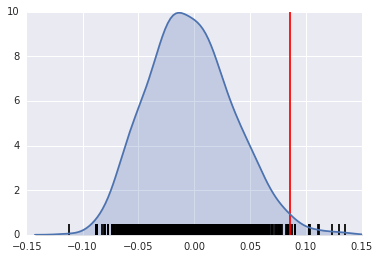

In [16]:
sns.kdeplot(I_HR90.sim, shade=True)
plt.vlines(I_HR90.sim, 0, 0.5)
plt.vlines(I_HR90.I, 0, 10, 'r')
plt.xlim([-0.15, 0.15])

Instead, if our $I$ statistic were close to our expected value, `I_HR90.EI`, our plot might look like this:

/home/serge/anaconda2/envs/gds-scipy16/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


(-0.15, 0.15)

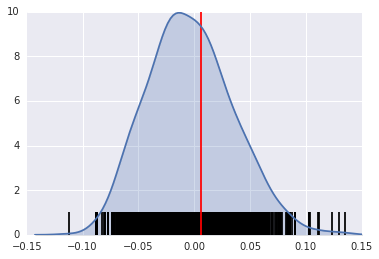

In [17]:
sns.kdeplot(I_HR90.sim, shade=True)
plt.vlines(I_HR90.sim, 0, 1)
plt.vlines(I_HR90.EI+.01, 0, 10, 'r')
plt.xlim([-0.15, 0.15])

The result of applying Moran's I is that we conclude the map pattern is not spatially random, but instead there is a signficant spatial association in homicide rates in Texas counties in 1990.

This result applies to the map as a whole, and is sometimes referred to as "global spatial autocorrelation". Next we turn to a local analysis where the attention shifts to detection of hot spots, cold spots and spatial outliers.

## Local Autocorrelation Statistics

In addition to the Global autocorrelation statistics, PySAL has many local autocorrelation statistics. Let's compute a local Moran statistic for the same data shown above:

In [18]:
LMo_HR90 = ps.Moran_Local(data.HR90.values, W)

Now, instead of a single $I$ statistic, we have an *array* of local $I_i$ statistics, stored in the `.Is` attribute, and p-values from the simulation are in `p_sim`. 

In [19]:
LMo_HR90.Is[0:10], LMo_HR90.p_sim[0:10]

(array([ 1.12087323,  0.47485223, -1.22758423,  0.93868661,  0.68974296,
         0.78503173,  0.71047515,  0.41060686,  0.00740368,  0.14866352]),
 array([ 0.013,  0.169,  0.037,  0.015,  0.002,  0.009,  0.053,  0.063,
         0.489,  0.119]))

We can adjust the number of permutations used to derive every *pseudo*-$p$ value by passing a different `permutations` argument:

In [20]:
LMo_HR90 = ps.Moran_Local(data.HR90.values, W, permutations=9999)

In addition to the typical clustermap, a helpful visualization for LISA statistics is a Moran scatterplot with statistically significant LISA values highlighted. 

This is very simple, if we use the same strategy we used before:

First, construct the spatial lag of the covariate:

In [21]:
Lag_HR90 = ps.lag_spatial(W, data.HR90.values)
HR90 = data.HR90.values

Then, we want to plot the statistically-significant LISA values in a different color than the others. To do this, first find all of the statistically significant LISAs. Since the $p$-values are in the same order as the $I_i$ statistics, we can do this in the following way

In [22]:
sigs = HR90[LMo_HR90.p_sim <= .001]
W_sigs = Lag_HR90[LMo_HR90.p_sim <= .001]
insigs = HR90[LMo_HR90.p_sim > .001]
W_insigs = Lag_HR90[LMo_HR90.p_sim > .001]

Then, since we have a lot of points, we can plot the points with a statistically insignficant LISA value lighter using the `alpha` keyword. In addition, we would like to plot the statistically significant points in a dark red color. 

In [23]:
b,a = np.polyfit(HR90, Lag_HR90, 1)

Matplotlib has a list of [named colors](http://matplotlib.org/examples/color/named_colors.html) and will interpret colors that are provided in hexadecimal strings:

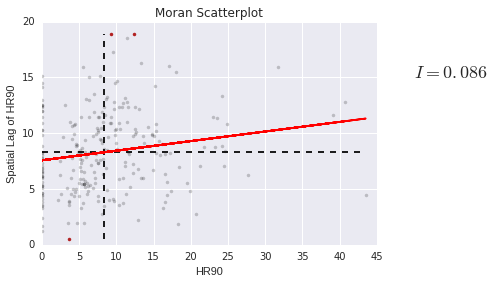

In [24]:
plt.plot(sigs, W_sigs, '.', color='firebrick')
plt.plot(insigs, W_insigs, '.k', alpha=.2)
 # dashed vert at mean of the last year's PCI
plt.vlines(HR90.mean(), Lag_HR90.min(), Lag_HR90.max(), linestyle='--')
 # dashed horizontal at mean of lagged PCI
plt.hlines(Lag_HR90.mean(), HR90.min(), HR90.max(), linestyle='--')

# red line of best fit using global I as slope
plt.plot(HR90, a + b*HR90, 'r')
plt.text(s='$I = %.3f$' % I_HR90.I, x=50, y=15, fontsize=18)
plt.title('Moran Scatterplot')
plt.ylabel('Spatial Lag of HR90')
plt.xlabel('HR90')

We can also make a LISA map of the data. 

In [25]:
sig = LMo_HR90.p_sim < 0.05

In [26]:
sig.sum()

44

In [27]:
hotspots = LMo_HR90.q==1 * sig

In [28]:
hotspots.sum()

10

In [29]:
coldspots = LMo_HR90.q==3 * sig

In [30]:
coldspots.sum()

17

In [31]:
data.HR90[hotspots]

98      9.784698
132    11.435106
164    17.129154
166    11.148272
209    13.274924
229    12.371338
234    31.721863
236     9.584971
239     9.256549
242    18.062652
Name: HR90, dtype: float64

In [32]:
data[hotspots]

,NAME,STATE_NAME,STATE_FIPS,CNTY_FIPS,FIPS,STFIPS,COFIPS,FIPSNO,SOUTH,HR60,...,BLK90,GI59,GI69,GI79,GI89,FH60,FH70,FH80,FH90,geometry
98,Ellis,Texas,48,139,48139,48,139,48139,1,9.217652,...,10.009746,0.325785,0.365177,0.352516,0.372783,12.418831,10.5,9.076165,12.031635,<pysal.cg.shapes.Polygon object at 0x7fd6cc81a...
132,Hudspeth,Texas,48,229,48229,48,229,48229,1,9.971084,...,0.514580,0.312484,0.373474,0.440944,0.476631,14.115899,7.7,8.959538,11.363636,<pysal.cg.shapes.Polygon object at 0x7fd6cc7a1...
164,Jeff Davis,Texas,48,243,48243,48,243,48243,1,0.000000,...,0.359712,0.316019,0.367719,0.437014,0.399655,14.438503,10.1,5.970149,8.255159,<pysal.cg.shapes.Polygon object at 0x7fd6cc7ae...
166,Schleicher,Texas,48,413,48413,48,413,48413,1,0.000000,...,0.903010,0.300170,0.387936,0.419192,0.419375,10.155148,9.8,7.222914,8.363636,<pysal.cg.shapes.Polygon object at 0x7fd6cc7ae...
209,Chambers,Texas,48,071,48071,48,71,48071,1,3.211613,...,12.694146,0.299847,0.374105,0.378431,0.364723,9.462037,9.2,8.568120,10.598911,<pysal.cg.shapes.Polygon object at 0x7fd6cc7bb...
229,Frio,Texas,48,163,48163,48,163,48163,1,3.296414,...,1.358373,0.390980,0.463020,0.435098,0.473507,14.665445,9.4,11.842919,18.330362,<pysal.cg.shapes.Polygon object at 0x7fd6cc7c2...
234,La Salle,Texas,48,283,48283,48,283,48283,1,0.000000,...,1.008755,0.421556,0.482174,0.489173,0.492687,18.167702,14.1,13.052937,20.088626,<pysal.cg.shapes.Polygon object at 0x7fd6cc7c2...
236,Dimmit,Texas,48,127,48127,48,127,48127,1,0.000000,...,0.575098,0.417976,0.452789,0.456840,0.479503,13.826043,10.1,10.944363,17.769080,<pysal.cg.shapes.Polygon object at 0x7fd6cc7c2...
239,Webb,Texas,48,479,48479,48,479,48479,1,2.057899,...,0.117083,0.382594,0.443082,0.439100,0.461075,20.292824,15.5,17.419676,20.521271,<pysal.cg.shapes.Polygon object at 0x7fd6cc7c2...
242,Duval,Texas,48,131,48131,48,131,48131,1,2.487934,...,0.092894,0.370217,0.427660,0.421041,0.458937,15.829478,13.2,12.803677,20.699881,<pysal.cg.shapes.Polygon object at 0x7fd6cc7c2...


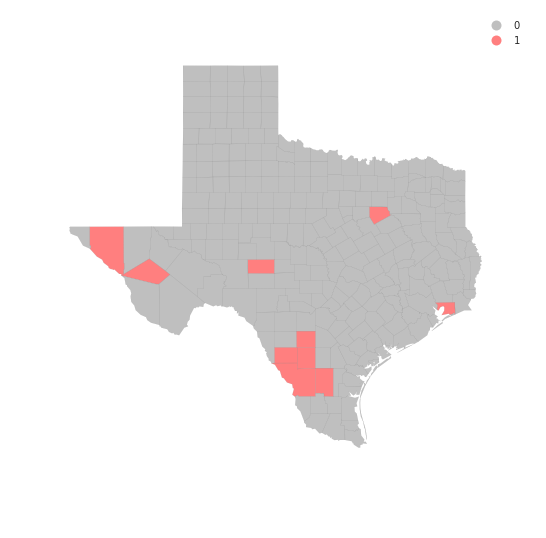

In [33]:
from matplotlib import colors
hmap = colors.ListedColormap(['grey', 'red'])
f, ax = plt.subplots(1, figsize=(9, 9))
tx.assign(cl=hotspots*1).plot(column='cl', categorical=True, \
        k=2, cmap=hmap, linewidth=0.1, ax=ax, \
        edgecolor='grey', legend=True)
ax.set_axis_off()
plt.show()

In [34]:
data.HR90[coldspots]

0      0.000000
3      0.000000
4      3.651767
5      0.000000
13     5.669899
19     3.480743
21     3.675119
32     2.211607
33     4.718762
48     5.509870
51     0.000000
62     3.677958
69     0.000000
81     0.000000
87     3.699593
140    8.125292
233    5.304688
Name: HR90, dtype: float64

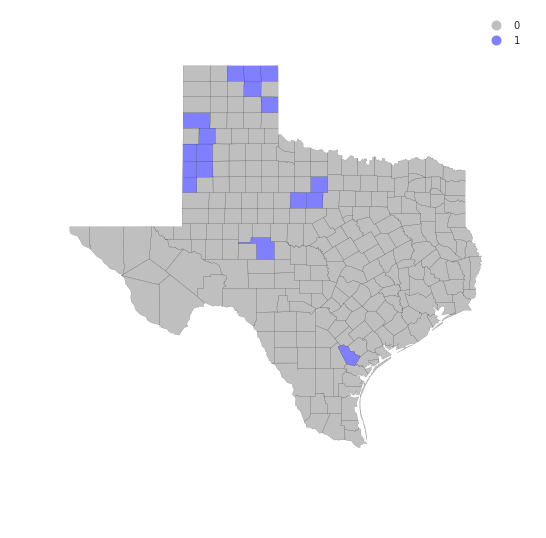

In [35]:
cmap = colors.ListedColormap(['grey', 'blue'])
f, ax = plt.subplots(1, figsize=(9, 9))
tx.assign(cl=coldspots*1).plot(column='cl', categorical=True, \
        k=2, cmap=cmap, linewidth=0.1, ax=ax, \
        edgecolor='black', legend=True)
ax.set_axis_off()
plt.show()


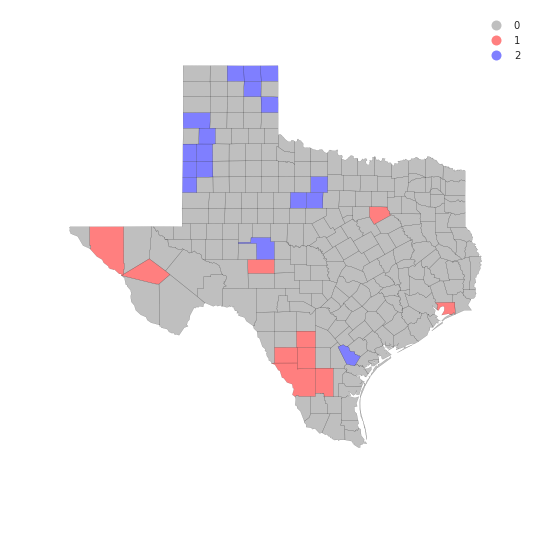

In [36]:
from matplotlib import colors
hcmap = colors.ListedColormap(['grey', 'red','blue'])
hotcold = hotspots*1 + coldspots*2
f, ax = plt.subplots(1, figsize=(9, 9))
tx.assign(cl=hotcold).plot(column='cl', categorical=True, \
        k=2, cmap=hcmap,linewidth=0.1, ax=ax, \
        edgecolor='black', legend=True)
ax.set_axis_off()
plt.show()

/home/serge/anaconda2/envs/gds-scipy16/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


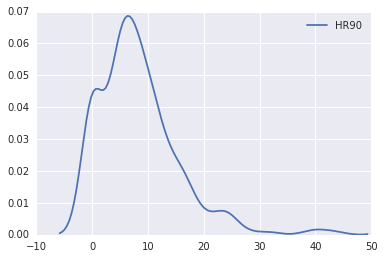

In [37]:
sns.kdeplot(data.HR90)

/home/serge/anaconda2/envs/gds-scipy16/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


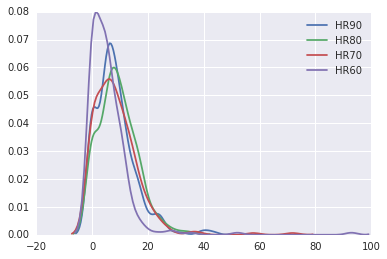

In [38]:
sns.kdeplot(data.HR90)
sns.kdeplot(data.HR80)
sns.kdeplot(data.HR70)
sns.kdeplot(data.HR60)

In [39]:
data.HR90.mean()

8.302494460285041

In [40]:
data.HR90.median()

7.23234613355

## Exercises

1. Repeat the global analysis for the years 1960, 70, 80 and compare the results to what we found in 1990.
2. The local analysis can also be repeated for the other decades. How many counties are hot spots in each of the periods?
3. The recent [Brexit vote](http://www.bbc.com/news/uk-politics-32810887) provides a timely example where local spatial autocorrelation analysis can provide interesting insights.  One [local analysis of the vote to leave](https://gist.github.com/darribas/691ad184280590d1219ffcf9a1678030) has recently been repored. Extend this to do an analysis of the attribute `Pct_remain`. Do the hot spots for the leave vote concord with the cold spots for the remain vote?